c:\users\debora\anaconda3\envs\ai_env\lib\site-packages\ipykernel_launcher.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # This is added back by InteractiveShellApp.init_path()


Using Tensorflow: 2.6.0
Found 13957 files belonging to 2 classes.
Using 11166 files for training.
Found 13957 files belonging to 2 classes.
Using 2791 files for validation.
x_train.shape:  (15, 128, 128, 3)
y_train.shape:  (15, 2)
x_test.shape:  (15, 128, 128, 3)
y_test.shape:  (15, 2)
['normal', 'covid']
0.0 0.95888484
Numarul de clase unice: 2

Nr total imagini dataset: 13957
Train: nr imagini: 11166 Test: nr imagini: 2791
Nr iteratii/epoca: 744

Epoch 0: Loss: 0.4850804360222913 Acc: 79.12412681354111%
Epoch 1: Loss: 0.4007429993881654 Acc: 84.88267956295898%
Epoch 2: Loss: 0.33366279454240877 Acc: 89.62027583736342%
Epoch 3: Loss: 0.2856803290215471 Acc: 92.93390650188071%
Epoch 4: Loss: 0.25207253025033544 Acc: 94.50116424861186%
Epoch 5: Loss: 0.21933977981348352 Acc: 95.83557227297152%
Epoch 6: Loss: 0.1945572344571232 Acc: 96.8654845065377%
Epoch 7: Loss: 0.17401366681486408 Acc: 97.42074153680817%
Epoch 8: Loss: 0.15566340858812736 Acc: 97.94017553286764%
Epoch 9: Loss: 0.1398

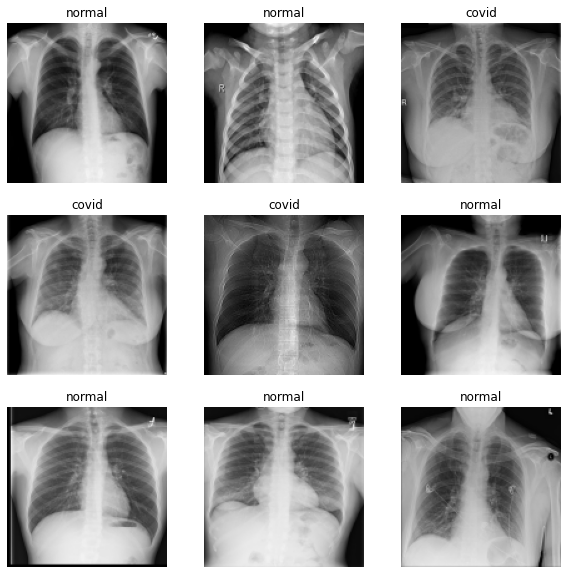

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
import pathlib as pt
import yaml

config = None
with open('config.yml') as f: # reads .yml/.yaml files
    config = yaml.load(f)

print(f"Using Tensorflow: {tf.__version__}")
# Date de training
DATA_PATH = pt.Path(r"C:\Users\Debora\Desktop\AI\Teme_suplimentare\retele_convolutionale\covid_dataset")
VAL_SPLIT = 0.2
BATCH_SIZE = config['bs']
img_size = config['size']

# Atentie!!!
# image_dataset_from_directory(main_directory, labels='categorical') returneaza imagini din subdirectoarele `covid` si `normal`
# impreuna cu etichetele 0 and 1 (0 corespunde cu `covid` si 1 corespunde cu `normal`, adica ordine alfabetica)
# Pentru a schimba ordinea se va da o lista explicita de `class_names`

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=img_size,
  class_names=['normal', 'covid'],
  label_mode='categorical', # Codificam clasele cu un vector de probabilitati. 
  batch_size=BATCH_SIZE)

# Date de testing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_PATH,
  validation_split=VAL_SPLIT,
  subset="validation",
  seed=123,
  shuffle=False,
  image_size=img_size,
  class_names=['normal', 'covid'],
  label_mode='categorical',
  batch_size=BATCH_SIZE)


x_train, y_train = next(iter(train_ds))
# Parcurgand obiectul de tip tf.Dataset obtinem tensori de imagini si etichete cu shape-ul [batch_size, height, width, nr_channels]
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)

x_test, y_test = next(iter(test_ds))
# La fel si pentru setul de test [batch_size, height, width, nr_channels]
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

# Numele etichetelor poate fi determinat cu ajutorul atributului `class_names`
class_names = train_ds.class_names
print(class_names)
# Vizualizarea imaginilor
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
# plt.show()


# Normalizarea setului de date
# Se aplica un start the normalizare dataset-ul de antrenare si testare
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]

# Imaginile vor avea valori in intervalul `[0,1]`.
print(np.min(first_image), np.max(first_image))

# Atentie! Normalizarea se face si pentru datasetul de testare
normalized_test_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Dimensiunea imaginilor
image_dim = x_train[0].shape

# Determinam numarul de clase unice. Acestea sunt one-hot encoded
nr_clase = len(np.unique(y_train))
print(f'Numarul de clase unice: {nr_clase}')

# API secvential
n1 = config['n1']
n2 = config['n2']
n3 = config['n3']

# Definim arhitectura retelei convolutionale
model = Sequential()
model.add(Conv2D(n1, config['conv1'], activation='relu', padding='valid', input_shape=image_dim))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(n2, config['conv2'], activation='relu', padding='valid'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(n3, activation='relu'))
model.add(Dense(nr_clase, activation='softmax'))
# model.summary()

# Antrenarea modelului
loss = tf.keras.losses.CategoricalCrossentropy()  # Functia loss
opt = tf.keras.optimizers.Adam(learning_rate=config['lr'])  # Optimizatorul
model.compile(optimizer=config['opt'], loss=loss)  # Compilarea modelului

# Calcularea nr total de imagini. 
# daca ver tensorflow < 2.4.0
# Se cauta toate tipurile de imagini din locatia DATA_PATH 
# file_types = ['.jpg', '.jpeg', '.png']
# dataset_size = len([p for p in DATA_PATH.rglob("*") if p.suffix in file_types]) # nr total imagini

# Calcularea nr de imagini in setul de antrenare si cel de testare
# test_size = int(dataset_size * VAL_SPLIT)
# train_size = dataset_size - test_size

# tensorflow v > 2.4.0
train_size = len(train_ds.file_paths) 
test_size = len(test_ds.file_paths)
dataset_size = train_size + test_size

print(f"\nNr total imagini dataset: {dataset_size}")
print(f"Train: nr imagini: {train_size} Test: nr imagini: {test_size}")

nr_epochs = config['n_epochs']
nr_train_iterations = train_size // BATCH_SIZE
print(f"Nr iteratii/epoca: {nr_train_iterations}\n")


# Pentru optimizarea citirii de pe disk https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance
AUTOTUNE = tf.data.AUTOTUNE
normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Bucla de antrenare. Se va folosi datasetul normalizat!!
evolutie_acc = []
evolutie_loss = []

for ep in range(nr_epochs):
    predictions = []
    true_labels = []
    loss_per_epoch = 0

    for step, (batch_data, batch_labels) in enumerate(normalized_train_ds):
        # batch_data = x_train[it * batch_size: it * batch_size + batch_size, :]
        # batch_labels = y_train_labels[it * batch_size: it * batch_size + batch_size]
        # print(batch_data.shape, batch_labels.shape)

        err = model.train_on_batch(batch_data, batch_labels)
        loss_per_epoch = loss_per_epoch + err
        pred_probs = model.predict_on_batch(batch_data)

        pred_label = np.argmax(pred_probs, axis=1)

        predictions = np.concatenate((predictions, pred_label))
        true_labels = np.concatenate((true_labels, np.argmax(batch_labels, axis=1)))

    evolutie_loss.append(loss_per_epoch/nr_train_iterations)

    # Calculam acuratetea
    acc = np.sum(predictions == true_labels) / len(predictions)
    evolutie_acc.append(acc)
    print(f'Epoch {ep}: Loss: {loss_per_epoch / nr_train_iterations} Acc: {acc * 100}%')

    # Salvam ponderile modelului dupa fiecare epoca
    model.save_weights('my_model')
    train_iter = iter(train_ds)

# Testarea modelului
# Incarcam ponderile modelul antrenat
model.load_weights('my_model')

predictions = []
test_labels = []
for step, (batch_data, batch_labels) in enumerate(normalized_test_ds):
    # batch_data = x_test[it * batch_size: it * batch_size + batch_size, :]
    current_pred_probs = model.predict_on_batch(batch_data)
    current_pred_probs = np.argmax(current_pred_probs, axis=1)

    predictions = np.concatenate((predictions, current_pred_probs))
    test_labels = np.concatenate((test_labels, np.argmax(batch_labels, axis=1)))


acc = np.sum(predictions == test_labels) / len(predictions)
print(f'\nAcuratetea la test este {acc * 100}%')
